In [1]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)



import matplotlib.pyplot as plt
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
args = {
    'data_dir': 'data/',
    'model_type':  'xlnet',
    'model_name': 'xlnet-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 5,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': True,
    'reprocess_input_data': True,
    'notes': 'Using Yelp Reviews dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': True,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 4e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'xlnet-base-cased',
 'model_type': 'xlnet',
 'notes': 'Using Yelp Reviews dataset',
 'num_train_epochs': 5,
 'output_dir': 'outputs/',
 'output_mode': 'classification',
 'overwrite_output_dir': True,
 'reprocess_input_data': True,
 'save_steps': 2000,
 'task_name': 'binary',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [4]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [5]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [6]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

In [7]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /u/spa-d2/grad/mna245/.cache/torch/pytorch_transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": "binary",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": tr

In [8]:
model = model_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /u/spa-d2/grad/mna245/.cache/torch/pytorch_transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.ef1824921bc0786e97dc88d55eb17aabf18aac90f24bd34c0650529e7ba27d6f
INFO:pytorch_transformers.modeling_utils:Model config {
  "attn_type": "bi",
  "bi_data": false,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "ff_activation": "gelu",
  "finetuning_task": null,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "n_head": 12,
  "n_layer": 12,
  "n_token": 32000,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,


In [9]:
model.to(device);

In [10]:
task = args['task_name']

processor = processors[task]()
label_list = processor.get_labels()
num_labels = len(label_list)

In [11]:
def load_and_cache_examples(task, tokenizer, evaluate=False):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
            cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
            cls_token=tokenizer.cls_token,
            sep_token=tokenizer.sep_token,
            cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
            pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
            pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [12]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    n_it = 0
    for _ in train_iterator:
        n_it +=1
        print("n_it: ",n_it)
        #if n_it >=3:
        #    args['gradient_accumulation_steps'] +=1
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [13]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, evaluate=True)
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            print(outputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [14]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer)
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data/
100%|██████████| 700/700 [00:23<00:00, 29.20it/s]
INFO:__main__:Saving features into cached file data/cached_train_bert-base-uncased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 700
INFO:__main__:  Num Epochs = 5
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 440
Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
n_it:  1


HBox(children=(IntProgress(value=0, description='Iteration', max=88, style=ProgressStyle(description_width='initial')), HTML(value='')))

0.736769

/u/spa-d2/grad/mna245/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:73: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.675974Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
0.779984Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
0.429582Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.665977

Epoch:  20%|██        | 1/5 [00:15<01:02, 15.60s/it]

0.206784
n_it:  2


HBox(children=(IntProgress(value=0, description='Iteration', max=88, style=ProgressStyle(description_width='initial')), HTML(value='')))

0.106833

Epoch:  40%|████      | 2/5 [00:31<00:46, 15.60s/it]


n_it:  3


HBox(children=(IntProgress(value=0, description='Iteration', max=88, style=ProgressStyle(description_width='initial')), HTML(value='')))

0.605805

Epoch:  60%|██████    | 3/5 [00:46<00:31, 15.54s/it]

0.005388
n_it:  4


HBox(children=(IntProgress(value=0, description='Iteration', max=88, style=ProgressStyle(description_width='initial')), HTML(value='')))

0.001710

Epoch:  80%|████████  | 4/5 [01:01<00:15, 15.41s/it]


n_it:  5


HBox(children=(IntProgress(value=0, description='Iteration', max=88, style=ProgressStyle(description_width='initial')), HTML(value='')))

0.000788

Epoch: 100%|██████████| 5/5 [01:16<00:00, 15.34s/it]
INFO:__main__: global_step = 440, average loss = 0.23126339555125344


In [15]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))    

INFO:__main__:Saving model checkpoint to outputs/


In [15]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in checkpoints:
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        print("global_step", global_step)
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
        result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
        results.update(result)


INFO:__main__:Evaluate the following checkpoints: ['outputs']


global_step 


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 687/687 [00:12<00:00, 54.22it/s]
INFO:__main__:Saving features into cached file data/cached_dev_xlnet-base-cased_128_binary
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 687
INFO:__main__:  Batch size = 8


HBox(children=(IntProgress(value=0, description='Evaluating', max=86, style=ProgressStyle(description_width='initial')), HTML(value='')))

(tensor(2.0272, device='cuda:0'), tensor([[ 0.6726, -0.7952],
        [-3.5099,  3.6768],
        [-3.5650,  3.7450],
        [ 0.5165, -1.3429],
        [-3.2236,  3.8345],
        [ 3.2463, -3.6369],
        [ 1.8986, -2.7977],
        [-3.2999,  3.7743]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(0.9375, device='cuda:0'), tensor([[-3.2762,  3.9448],
        [-3.1806,  3.8222],
        [-3.5450,  3.9464],
        [ 2.6947, -3.1245],
        [-3.2391,  3.8407],
        [-3.2741,  3.6918],
        [-3.4677,  3.5930],
        [-3.3419,  3.7866]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(1.6843, device='cuda:0'), tensor([[-3.0387,  3.7219],
        [-2.8399,  3.4074],
        [ 2.9887, -3.5995],
        [-3.2544,  3.9010],
        [-2.9703,  3.7595],
        [-3.3960,  3.8441],
        [-3.2688,  3.8003],
        [-3.3119,  3.9063]], device='cuda:0'), (None, None, None, No

(tensor(2.1126, device='cuda:0'), tensor([[-3.2434,  3.9056],
        [-2.7075,  3.6450],
        [-3.2374,  3.9146],
        [-2.5663,  3.4737],
        [-1.9774,  2.3366],
        [ 1.9991, -2.6997],
        [-2.8803,  3.6360],
        [ 3.0822, -3.7976]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(1.7364, device='cuda:0'), tensor([[-3.1427,  3.5045],
        [-3.1724,  3.8813],
        [ 3.2472, -3.7344],
        [-3.2526,  3.8011],
        [-3.3526,  3.7659],
        [-3.3639,  3.7602],
        [-3.2776,  3.9566],
        [-3.1323,  3.6271]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(2.5762, device='cuda:0'), tensor([[-2.9317,  3.6909],
        [-3.2520,  3.8781],
        [-3.3220,  3.8885],
        [-3.2123,  3.8104],
        [ 3.2182, -3.4815],
        [ 2.3027, -2.9774],
        [ 3.3171, -3.8244],
        [-3.1677,  3.7851]], device='cuda:0'), (None, None, None, No

(tensor(1.7585, device='cuda:0'), tensor([[-3.3086,  3.6329],
        [-3.3886,  3.7253],
        [ 2.9441, -3.6939],
        [-2.9690,  3.6749],
        [-3.3223,  3.8386],
        [-3.3039,  3.8811],
        [-3.1148,  4.0035],
        [ 3.0597, -3.5954]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(3.9864, device='cuda:0'), tensor([[ 2.6872, -3.0974],
        [-3.5301,  3.8125],
        [-1.1083,  1.7335],
        [-3.5301,  3.8125],
        [-3.1083,  3.6758],
        [-3.3916,  3.8856],
        [-3.1911,  3.7667],
        [ 0.3920, -0.9174]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(0.9425, device='cuda:0'), tensor([[-3.4187,  3.6976],
        [-3.4614,  3.6661],
        [-3.5537,  3.7869],
        [ 2.9577, -3.1371],
        [-0.8353,  1.5392],
        [-2.1471,  2.9170],
        [-3.4319,  3.8033],
        [-3.1277,  3.7919]], device='cuda:0'), (None, None, None, No

(tensor(2.5589, device='cuda:0'), tensor([[-3.2118,  3.7951],
        [ 1.5980, -1.6989],
        [-3.2902,  3.8692],
        [-3.0789,  3.7672],
        [-3.4017,  3.6863],
        [-3.2469,  3.9050],
        [-3.3659,  3.8286],
        [-1.2708,  1.4440]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(2.2782, device='cuda:0'), tensor([[-3.0447,  3.6214],
        [-3.3797,  3.8160],
        [ 3.0128, -3.5035],
        [-1.0581,  2.4097],
        [-3.3651,  3.7992],
        [ 3.4844, -3.7189],
        [-3.5239,  3.9353],
        [-1.1850,  1.0899]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))
(tensor(1.8203, device='cuda:0'), tensor([[-3.0236,  3.5760],
        [ 3.1243, -3.9664],
        [ 0.6350,  0.2505],
        [-3.4094,  4.0359],
        [-3.0086,  3.6190],
        [-3.2983,  3.7518],
        [-3.3893,  3.6877],
        [ 2.4171, -3.3808]], device='cuda:0'), (None, None, None, No

INFO:__main__:***** Eval results  *****
INFO:__main__:  fn = 9
INFO:__main__:  fp = 183
INFO:__main__:  mcc = 0.5075483675930825
INFO:__main__:  tn = 155
INFO:__main__:  tp = 340


(tensor(2.0542, device='cuda:0'), tensor([[-3.2794,  3.7581],
        [-3.1261,  3.7981],
        [-3.2962,  3.8588],
        [-3.1848,  3.8383],
        [-2.9090,  3.5642],
        [-3.4318,  3.7834],
        [-2.5337,  3.1348]], device='cuda:0'), (None, None, None, None, None, None, None, None, None, None, None, None))



In [15]:
results

{'fn_': 31, 'fp_': 29, 'mcc_': 0.42715677418452497, 'tn_': 54, 'tp_': 109}

In [16]:
acc = (results['tn_'] + results['tp_'])/(results['fn_'] + results['fp_'] + results['tn_'] + results['tp_'])
acc

0.7309417040358744

In [17]:
results['fn_'] + results['fp_'] + results['tn_'] + results['tp_']

223

In [18]:
precision = results['tp_']/(results['tp_'] + results['fp_'])
precision

0.7898550724637681

In [19]:
recall = results['tp_']/(results['tp_']+results['fn_'])
recall

0.7785714285714286

In [20]:
f1 = 2*((precision*recall)/(precision+recall))
f1

0.7841726618705036

In [23]:
epoch_list = [2,3,4,5]

In [23]:
acc_list = [0.6780185758513931, 0.7027863777089783, 0.7120743034055728, 0.70]

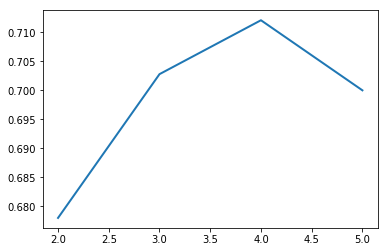

In [24]:
plt.plot(epoch_list, acc_list, linewidth=2.0)

In [25]:
xl_epoch_list = [2,3,4,5]

In [26]:
xl_acc_list = [0.718266253869969, 0.7275541795665634, 0.739938080495356, 0.6965944272445821]